## Clustering 

In [1]:
#import packages

In [2]:
import pandas as pd
import numpy as np 
import geopandas
import json

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

#quadrat analysis
from pointpats import PointPattern, as_window
from pointpats import PoissonPointProcess as csr

#clustering
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import folium
from h3 import h3
from folium import plugins
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # plot styling

In [4]:
#The optimal number of clusters is the value that minimizes the AIC or BIC
#this is used for GM 
def number_of_clusters(cluster): 
    n_components = np.arange(1, 21)
    models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(cluster)
              for n in n_components]

    plt.plot(n_components, [m.bic(cluster) for m in models], label='BIC')
    plt.plot(n_components, [m.aic(cluster) for m in models], label='AIC')
    plt.legend(loc='best')
    plt.xlabel('n_components');

In [5]:
df_basis = pd.read_csv("Data/bonn_trips.csv")

### Quadrat Analysis

The Quadrat Analysis is used to check our data spatial data for Complete spatial randomness, hence a process in which points are distributed randomly. Based on the result it is possible to make assumptions about the possible clustering of spatial data. 

In [6]:
#just get the ones that are stations
df = df_basis[ df_basis['p_spot_start'] == True ]

In [7]:
#group by geographical data
df = df.groupby(['p_uid_start', 'latitude_start', 'longitude_start'], as_index=False).count()
df

,p_uid_start,latitude_start,longitude_start,Unnamed: 0,Code_18,index_right,index,index_start,p_place_type_start,datetime_start,...,Bonn,urban_fabric,discontinuous_urban_fabric,continuous_urban_fabric,industry_commercial,green_urban_area,agricultural_area,forest,water_courses,distance_next_station
0,10044279,50.739211,7.126598,1585,1585,1585,1585,1585,1585,1585,...,1585,1585,1585,1585,1585,1585,1585,1585,1585,1585
1,10044287,50.736767,7.080957,775,775,775,775,775,775,775,...,775,775,775,775,775,775,775,775,775,775
2,10044296,50.714610,7.160082,740,740,740,740,740,740,740,...,740,740,740,740,740,740,740,740,740,740
3,10044296,50.714610,7.160082,1342,1342,1342,1342,1342,1342,1342,...,1342,1342,1342,1342,1342,1342,1342,1342,1342,1342
4,10044315,50.717870,7.125487,590,590,590,590,590,590,590,...,590,590,590,590,590,590,590,590,590,590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,12528644,50.704497,7.112296,738,738,738,738,738,738,738,...,738,738,738,738,738,738,738,738,738,738
85,12528644,50.704497,7.112296,107,107,107,107,107,107,107,...,107,107,107,107,107,107,107,107,107,107
86,12585369,50.715809,7.050042,134,134,134,134,134,134,134,...,134,134,134,134,134,134,134,134,134,134
87,12585369,50.715809,7.050042,223,223,223,223,223,223,223,...,223,223,223,223,223,223,223,223,223,223


In [8]:
pp = df[['latitude_start', 'longitude_start']]

In [9]:
pp = pp.rename_axis('ID').values
print(pp)

[[50.739211    7.126598  ]
 [50.7367675   7.0809567 ]
 [50.71460951  7.16008186]
 [50.71460951  7.16008186]
 [50.71787019  7.12548673]
 [50.71787019  7.12548673]
 [50.71788038  7.12545991]
 [50.71757     7.090974  ]
 [50.7027842   7.1002901 ]
 [50.734919    7.102499  ]
 [50.725962    7.094151  ]
 [50.73621748  7.09460378]
 [50.73621748  7.09460378]
 [50.73432977  7.09762931]
 [50.73432977  7.09762931]
 [50.71759508  7.11995602]
 [50.71759508  7.11995602]
 [50.7403457   7.0917284 ]
 [50.7368575   7.1059683 ]
 [50.735092    7.108273  ]
 [50.71794831  7.15412199]
 [50.718658    7.129261  ]
 [50.73009233  7.10827768]
 [50.73009233  7.10827768]
 [50.7284811   7.0852697 ]
 [50.710586    7.1268734 ]
 [50.72164347  7.14315712]
 [50.72164347  7.14315712]
 [50.749956    7.175042  ]
 [50.73656038  7.11734354]
 [50.73656038  7.11734354]
 [50.736871    7.1170619 ]
 [50.69709645  7.14167655]
 [50.69709645  7.14167655]
 [50.7259937   7.1112254 ]
 [50.72135479  7.0878607 ]
 [50.7270193   7.0812356 ]
 

In [10]:
#create the point pattern for the points consisting of longitudes and latitudes
pp_juv = PointPattern(pp)
pp_juv

In [11]:
pp_juv.summary()

Point Pattern
89 points
Bounding rectangle [(50.664601,7.033889), (50.75885200000001,7.1817219257355)]
Area of window: 0.013933401083498609
Intensity estimate for window: 6387.528749560157
           x         y
0  50.739211  7.126598
1  50.736767  7.080957
2  50.714610  7.160082
3  50.714610  7.160082
4  50.717870  7.125487


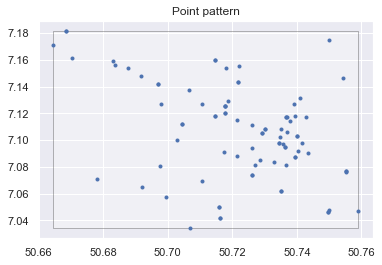

In [12]:
pp_juv.plot(window= True, title= "Point pattern")

In [13]:
import pointpats.quadrat_statistics as qs

In [14]:
#put qudrats over the the points 
q_r = qs.QStatistic(pp_juv,shape= "rectangle",nx = 3, ny = 3)

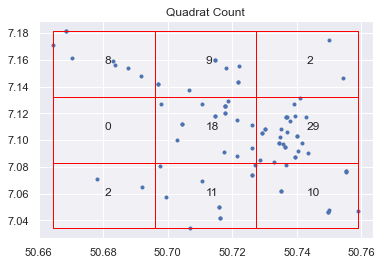

In [15]:
q_r.plot()

In [16]:
q_r.chi2 #chi-squared test statistic for the observed point pattern

66.62921348314606

In [17]:
q_r.df #degree of freedom


8

In [18]:
q_r.chi2_pvalue # analytical pvalue

2.2964789973883233e-11

In [19]:
#Since the p-value based on the analytical χ2 distribution is much smaller than 0.05. 
#We might determine that the underlying process is not CSR. The point pattern is not random. 
#We can also turn to empirical sampling distribution to ascertain our decision.

In [20]:
csr_process = csr(pp_juv.window, pp_juv.n, 999, asPP=True)

In [21]:
q_r_e = qs.QStatistic(pp_juv,shape= "rectangle",nx = 3, ny = 3, realizations = csr_process)


In [22]:
q_r_e.chi2_r_pvalue


0.001

In [23]:
#The pseudo p-value is 0.001, which is smaller than 0.05. Thus, we reject the null at the 95% confidence level.

Hence, we have found that the process isn't CSR and the distribution of the stations can be clustered. 

### Clustering with periodical data

In this section we are taking a look at how many trips have been made during a specific time frame. We will later check if there are any possible clusters regarding days or months or generally patterns we can find in our data. 

In [24]:
#making a new dataframe that is grouped by the date 
data = df_basis.groupby('datetime_start', as_index=False).count()
data = data[['datetime_start', 'index_start']]
data = data.set_index(pd.DatetimeIndex(data['datetime_start']))

In [25]:
#resample data to fill in the missing time values with null 
data = data.resample('1T').last().fillna(value=0)

In [26]:
data

,datetime_start,index_start
datetime_start,,
2019-01-20 00:04:00,2019-01-20 00:04:00,1.0
2019-01-20 00:05:00,0,0.0
2019-01-20 00:06:00,0,0.0
2019-01-20 00:07:00,0,0.0
2019-01-20 00:08:00,0,0.0
...,...,...
2019-12-31 23:50:00,0,0.0
2019-12-31 23:51:00,0,0.0
2019-12-31 23:52:00,0,0.0


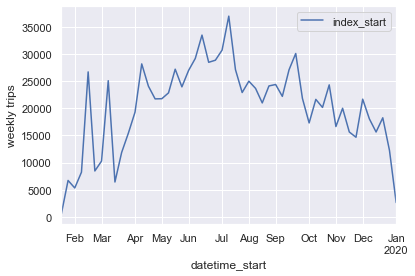

In [27]:
#resample the data to check for patterns over the whole year
data.resample('W').sum().plot()
plt.ylabel('weekly trips');

In [28]:
data = data.drop(columns='datetime_start')

In [29]:
data

,index_start
datetime_start,
2019-01-20 00:04:00,1.0
2019-01-20 00:05:00,0.0
2019-01-20 00:06:00,0.0
2019-01-20 00:07:00,0.0
2019-01-20 00:08:00,0.0
...,...
2019-12-31 23:50:00,0.0
2019-12-31 23:51:00,0.0
2019-12-31 23:52:00,0.0


In [30]:
#create a table that sums up the amount of trips over the day and dates
pivoted = data.pivot_table(index=data.index.date,
                           columns=data.index.hour,
                           aggfunc=np.sum,
                           fill_value=0)
pivoted.head()

index_start                                     ...           \
datetime_start          0  1   2   3  4   5   6   7   8    9   ...  14   15   
2019-01-20              27  9  17  13  7   1   6  15  26   18  ...  44   47   
2019-01-21               3  0   0   4  7  14  40  66  42   27  ...  48   86   
2019-01-22               4  1   1   2  3  23  37  91  55   33  ...  56  111   
2019-01-23               4  0   1   1  6  14  43  79  56   35  ...  58   81   
2019-01-24               8  1   0   5  2  18  49  72  58  807  ...  52   74   

                                                
datetime_start  16  17  18  19  20  21  22  23  
2019-01-20      37  33  38  23  20  14  10   6  
2019-01-21      85  68  53  40  22  35  15   3  
2019-01-22      79  76  53  44  37  18  15   7  
2019-01-23      80  73  59  45  25  32  20  17  
2019-01-24      83  80  60  41  30  26  21  11  

[5 rows x 24 columns]

In [31]:
#set down values that are too high and would build own clusters during the later processes
pivoted = pivoted.where(pivoted < 100, 100)
pivoted

index_start                                        ...       \
datetime_start          0   1    2   3   4   5   6   7   8    9   ...   14   
2019-01-20              27   9   17  13   7   1   6  15  26   18  ...   44   
2019-01-21               3   0    0   4   7  14  40  66  42   27  ...   48   
2019-01-22               4   1    1   2   3  23  37  91  55   33  ...   56   
2019-01-23               4   0    1   1   6  14  43  79  56   35  ...   58   
2019-01-24               8   1    0   5   2  18  49  72  58  100  ...   52   
...                    ...  ..  ...  ..  ..  ..  ..  ..  ..  ...  ...  ...   
2019-12-27              26  26   22  10   5  11  15  24  30   40  ...   81   
2019-12-28              33  41   38  22  15  10  10  13  18   31  ...  100   
2019-12-29              41  44  100  22   9  10   4   5  12   13  ...   75   
2019-12-30              37  21   24   7  15  11  15  24  41   38  ...   84   
2019-12-31              50  34   18   7   5  10   9   9  26   41  ...   83   

                                                        
datetime_start   15   16   17  18  19  20  21   22  23  
2019-01-20       47   37   33  38  23  20  14   10   6  
2019-01-21       86   85   68  53  40  22  35   15   3  
2019-01-22      100   79   76  53  44  37  18   15   7  
2019-01-23       81   80   73  59  45  25  32   20  17  
2019-01-24       74   83   80  60  41  30  26   21  11  
...             ...  ...  ...  ..  ..  ..  ..  ...  ..  
2019-12-27      100  100   94  99  72  79  83   58  39  
2019-12-28       79   72   80  89  76  74  53  100  44  
2019-12-29      100   72   69  52  64  58  36   37  22  
2019-12-30      100  100  100  92  96  60  53   43  40  
2019-12-31       88  100  100  84  82  70  43   49  50  

[346 rows x 24 columns]

In [32]:
X = pivoted.values
X.shape

(346, 24)

In [33]:
#use the pca for dimension reduction, so we can actually plot clusters
Xpca = PCA(0.6).fit_transform(X) #we are keeping 60% variance with 2 dimensions
Xpca.shape

(346, 2)

In [34]:
Xpca

array([[ 2.31464343e+02, -4.47721004e+01],
       [ 1.53768514e+02, -6.31891858e+01],
       [ 1.32824688e+02, -6.66131371e+01],
       [ 1.39809003e+02, -6.13462407e+01],
       [ 1.26086937e+02, -6.15632966e+01],
       [ 1.38917560e+02, -6.85574703e+01],
       [ 1.66342116e+02, -1.35610592e+01],
       [ 2.35533760e+02, -3.63657880e+01],
       [ 1.90514807e+02, -5.74819236e+01],
       [ 1.22000075e+02, -6.53822545e+01],
       [ 1.80075817e+02, -8.98033370e+01],
       [ 1.94787976e+02, -5.98101920e+01],
       [ 1.39753530e+02, -4.47361025e+01],
       [ 1.98884263e+02, -2.23765815e+01],
       [ 2.14760951e+02, -3.27858827e+01],
       [ 1.56922992e+02, -5.35677185e+01],
       [ 9.88636100e+01, -4.47884169e+01],
       [ 1.05379309e+02, -5.22434115e+01],
       [ 1.03732735e+02, -5.66766960e+01],
       [ 8.79936812e+01, -4.70245408e+01],
       [ 1.76687972e+02, -5.05627635e+00],
       [ 2.53681405e+02, -4.37976759e+01],
       [ 1.40561442e+02, -6.03509703e+01],
       [ 2.

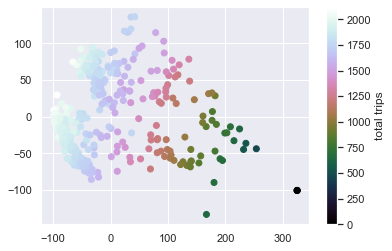

In [35]:
#plot the total amount of trips
total_trips = X.sum(1)
plt.scatter(Xpca[:, 0], Xpca[:, 1], c=total_trips,
            cmap='cubehelix')
plt.colorbar(label='total trips');

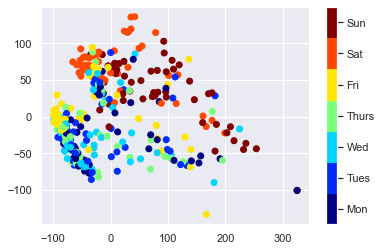

In [36]:
#on the total amount show which weekday they belong to
dayofweek = pd.to_datetime(pivoted.index).dayofweek
plt.scatter(Xpca[:, 0], Xpca[:, 1], c=dayofweek,
            cmap=plt.cm.get_cmap('jet', 7))
cb = plt.colorbar(ticks=range(7))
cb.set_ticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.clim(-0.5, 6.5);

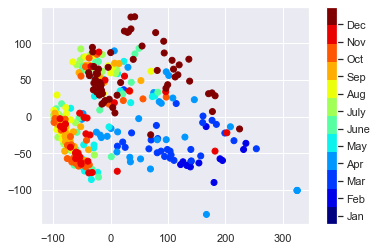

In [37]:
#which month do they belong to
month = pd.to_datetime(pivoted.index).month
plt.scatter(Xpca[:, 0], Xpca[:, 1], c=month,
            cmap=plt.cm.get_cmap('jet', 12))
cb = plt.colorbar(ticks=range(12))
cb.set_ticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.clim(-0.5, 12);

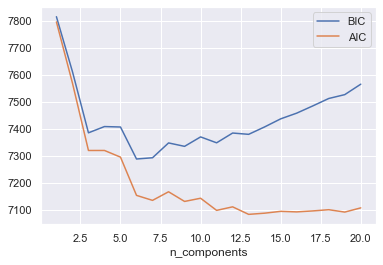

In [38]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(Xpca)
          for n in n_components]

plt.plot(n_components, [m.bic(Xpca) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xpca) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

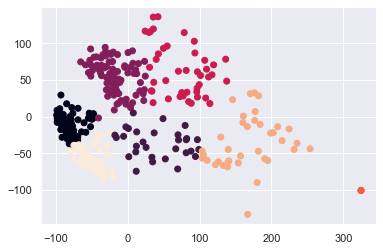

In [39]:
#Gaussian Mixture
gmm = GaussianMixture(7, covariance_type='spherical', random_state=0)
gmm.fit(Xpca)
cluster_label = gmm.predict(Xpca)
plt.scatter(Xpca[:, 0], Xpca[:, 1], c=cluster_label);

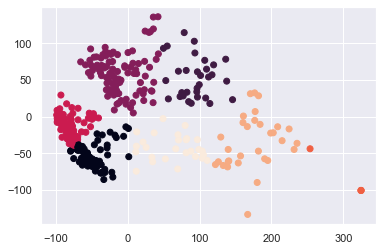

In [40]:
#KMeans
km = KMeans(n_clusters=7, init='k-means++', max_iter=300, algorithm='auto')
km.fit(Xpca)
cluster_label = km.predict(Xpca)
plt.scatter(Xpca[:, 0], Xpca[:, 1], c=cluster_label);

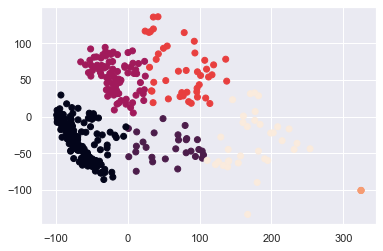

In [41]:
#6 clusters GMM
gmm = GaussianMixture(6, covariance_type='spherical', random_state=0)
gmm.fit(Xpca)
cluster_label2 = gmm.predict(Xpca)
plt.scatter(Xpca[:, 0], Xpca[:, 1], c=cluster_label2);

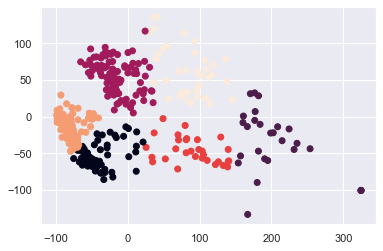

In [42]:
#6 clusters KM
km = KMeans(n_clusters=6, init='k-means++', max_iter=300, algorithm='auto')
km.fit(Xpca)
cluster_label = km.predict(Xpca)
plt.scatter(Xpca[:, 0], Xpca[:, 1], c=cluster_label);

In [43]:
#using clustering we can see there is one point that kmeans tends to put into a cluster with other points, whereas 
#GMM puts the point into an cluster for itself. It's the part that relates to a very low amount of trips 

In [44]:
pivoted['Cluster'] = cluster_label
data = data.join(pivoted['Cluster'], on=data.index.date)
data.head()

,index_start,Cluster
datetime_start,,
2019-01-20 00:04:00,1.0,1
2019-01-20 00:05:00,0.0,1
2019-01-20 00:06:00,0.0,1
2019-01-20 00:07:00,0.0,1
2019-01-20 00:08:00,0.0,1


In [45]:
by_hour = data.groupby(['Cluster', data.index.time]).mean()
by_hour.head()

index_start
Cluster                      
0       00:00:00     0.358209
        00:01:00     0.208955
        00:02:00     0.283582
        00:03:00     0.149254
        00:04:00     0.208955

In [46]:
#check how the different days are distributed
#we can color the days differently from the rest and see if there is any pattern found in the distribution of the data

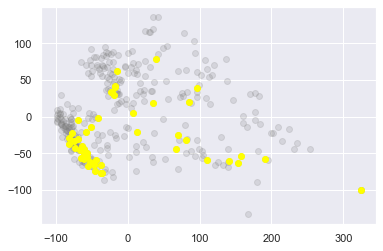

In [47]:
mondays = (dayofweek == 0)
plt.scatter(Xpca[:, 0], Xpca[:, 1], c='gray', alpha=0.2)
plt.scatter(Xpca[mondays, 0], Xpca[mondays, 1], c='yellow');

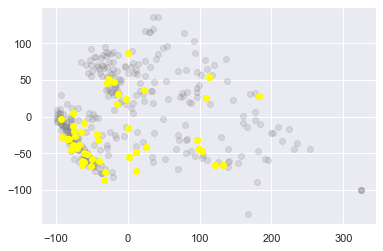

In [48]:
tuesdays = (dayofweek == 1)
plt.scatter(Xpca[:, 0], Xpca[:, 1], c='gray', alpha=0.2)
plt.scatter(Xpca[tuesdays, 0], Xpca[tuesdays, 1], c='yellow');

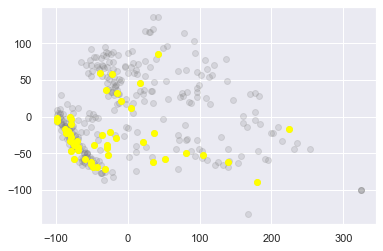

In [49]:
wednesdays = (dayofweek == 2)
plt.scatter(Xpca[:, 0], Xpca[:, 1], c='gray', alpha=0.2)
plt.scatter(Xpca[wednesdays, 0], Xpca[wednesdays, 1], c='yellow');

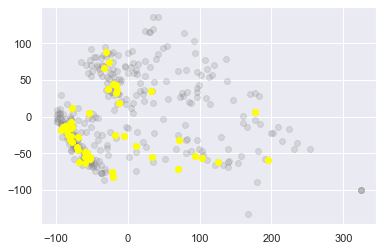

In [50]:
thursdays = (dayofweek == 3)
plt.scatter(Xpca[:, 0], Xpca[:, 1], c='gray', alpha=0.2)
plt.scatter(Xpca[thursdays, 0], Xpca[thursdays, 1], c='yellow');

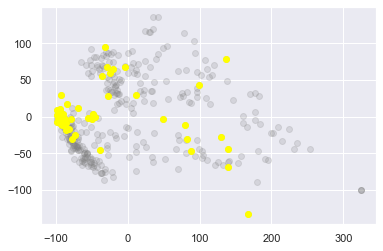

In [51]:
fridays = (dayofweek == 4)
plt.scatter(Xpca[:, 0], Xpca[:, 1], c='gray', alpha=0.2)
plt.scatter(Xpca[fridays, 0], Xpca[fridays, 1], c='yellow');

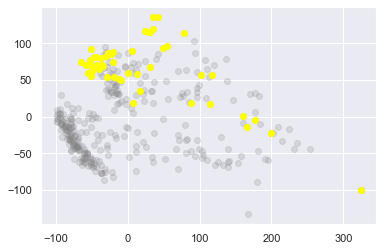

In [52]:
saturdays = (dayofweek == 5)
plt.scatter(Xpca[:, 0], Xpca[:, 1], c='gray', alpha=0.2)
plt.scatter(Xpca[saturdays, 0], Xpca[saturdays, 1], c='yellow');

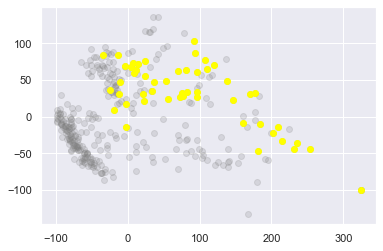

In [53]:
sundays = (dayofweek == 6)
plt.scatter(Xpca[:, 0], Xpca[:, 1], c='gray', alpha=0.2)
plt.scatter(Xpca[sundays, 0], Xpca[sundays, 1], c='yellow');

In [54]:
#it is also possible the check for certain days that show are differently distributed from the rest of the day data

In [55]:
weird_wednesdays = pivoted.index[wednesdays & (Xpca[:, 0] > 200)]
weird_wednesdays

Index([2019-12-25], dtype='object')

In [56]:
#first day of christmas

In [57]:
weird_tuesdays = pivoted.index[tuesdays & (Xpca[:, 0] > 150)]
weird_tuesdays

Index([2019-12-24], dtype='object')

In [58]:
#also christmas

In [59]:
weird_thursdays = pivoted.index[thursdays & (Xpca[:, 0] > 150)]
weird_thursdays

Index([2019-01-31, 2019-12-26], dtype='object')

In [60]:
#second day of christmas and day before new year

In [61]:
weird_fridays = pivoted.index[fridays & (Xpca[:, 1] < 0 )  & (Xpca[:, 0] > 100 )]
weird_fridays

Index([2019-01-25, 2019-02-01, 2019-03-01, 2019-03-15], dtype='object')

In [62]:
#first day is Allerheiligen and the other is also pretty close to christmas. Might that be that people still have free
#during that time. Universities in general are on vacation from before christmas till New Year

In [63]:
#next check how the different months are distributed

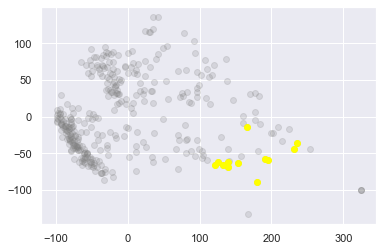

In [64]:
Jan = (month == 1)
plt.scatter(Xpca[:, 0], Xpca[:, 1], c='gray', alpha=0.2)
plt.scatter(Xpca[Jan, 0], Xpca[Jan, 1], c='yellow');

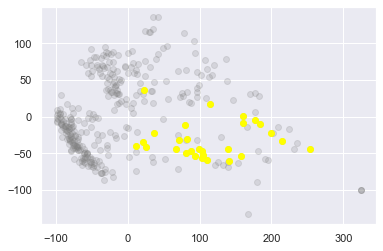

In [65]:
Feb = (month == 2)
plt.scatter(Xpca[:, 0], Xpca[:, 1], c='gray', alpha=0.2)
plt.scatter(Xpca[Feb, 0], Xpca[Feb, 1], c='yellow');

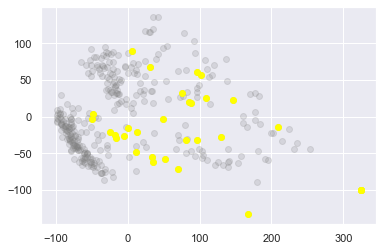

In [66]:
Mar = (month == 3)
plt.scatter(Xpca[:, 0], Xpca[:, 1], c='gray', alpha=0.2)
plt.scatter(Xpca[Mar, 0], Xpca[Mar, 1], c='yellow');

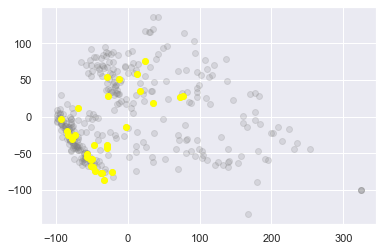

In [67]:
Apr = (month == 4)
plt.scatter(Xpca[:, 0], Xpca[:, 1], c='gray', alpha=0.2)
plt.scatter(Xpca[Apr, 0], Xpca[Apr, 1], c='yellow');

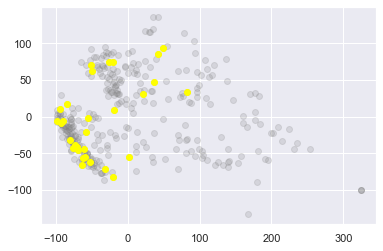

In [68]:
May = (month == 5)
plt.scatter(Xpca[:, 0], Xpca[:, 1], c='gray', alpha=0.2)
plt.scatter(Xpca[May, 0], Xpca[May, 1], c='yellow');

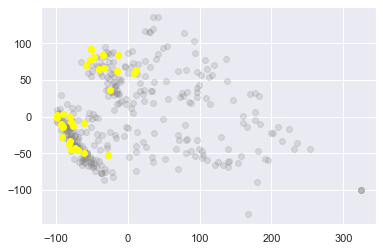

In [69]:
Jun = (month == 6)
plt.scatter(Xpca[:, 0], Xpca[:, 1], c='gray', alpha=0.2)
plt.scatter(Xpca[Jun, 0], Xpca[Jun, 1], c='yellow');

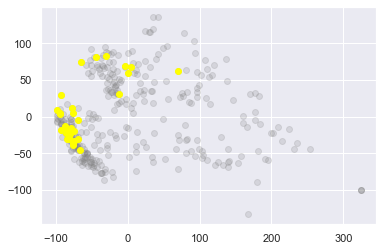

In [70]:
Jul = (month == 7)
plt.scatter(Xpca[:, 0], Xpca[:, 1], c='gray', alpha=0.2)
plt.scatter(Xpca[Jul, 0], Xpca[Jul, 1], c='yellow');

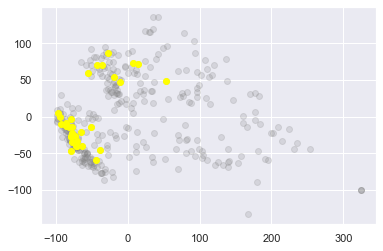

In [71]:
Aug = (month == 8)
plt.scatter(Xpca[:, 0], Xpca[:, 1], c='gray', alpha=0.2)
plt.scatter(Xpca[Aug, 0], Xpca[Aug, 1], c='yellow');

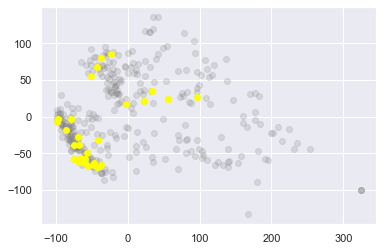

In [72]:
Sep = (month == 9)
plt.scatter(Xpca[:, 0], Xpca[:, 1], c='gray', alpha=0.2)
plt.scatter(Xpca[Sep, 0], Xpca[Sep, 1], c='yellow');

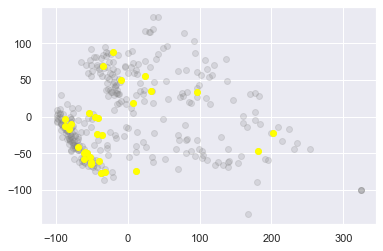

In [73]:
Oct = (month == 10)
plt.scatter(Xpca[:, 0], Xpca[:, 1], c='gray', alpha=0.2)
plt.scatter(Xpca[Oct, 0], Xpca[Oct, 1], c='yellow');

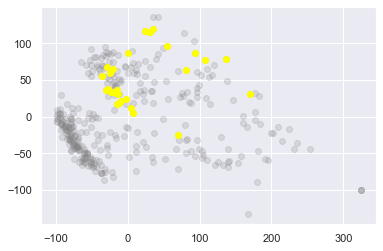

In [74]:
Nov = (month == 11)
plt.scatter(Xpca[:, 0], Xpca[:, 1], c='gray', alpha=0.2)
plt.scatter(Xpca[Nov, 0], Xpca[Nov, 1], c='yellow');

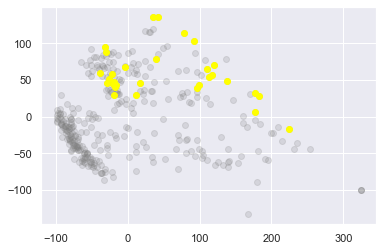

In [75]:
Dec = (month == 12)
plt.scatter(Xpca[:, 0], Xpca[:, 1], c='gray', alpha=0.2)
plt.scatter(Xpca[Dec, 0], Xpca[Dec, 1], c='yellow');

The periodical analysis didn't show any clear clusters. However, certain patterns can be seen. The weekend is generally situated in the upper area of the diagram. The week days are often situated in the lower area, though there are a lot of irregularities. Checking for points that are far away from the other points showed that most of the time it turns out the specific days like holidays or events. So even if this analysis didn't bring any clear clusters, it can still be considered valuable to be prepared for very specific dates. 
Month wise is can be said that the summer months are mostly situated on the left side of the diagram. November and December are mostly in the upper part, while the January is in the right lower corner. Though this might be due to the fact that there isn't a whole month of data for January.

### Clustering based on the availability of bikes at stations

#### K-Means

The following process was first just done for the start information, then later for the end information and lastly for the combined data. Since it turned out that the distributions were always mostly the same, we kept to the combined analysis where both start and end information go into the clustering. The missing differences between the different information is probably due to the fact that we are dealing with availability data and not trips. 

In [76]:
df_basis = pd.read_csv("Data/bonn_trips.csv")

In [77]:
data1 = df_basis[['p_uid_start', 'datetime_start', 'p_bikes_x', 'p_name_start', 'p_spot_start']]
data1 = data1.rename(columns={"p_uid_start": "p_uid", "datetime_start": "datetime", "p_bikes_x": "p_bikes", "p_name_start": "p_name", "p_spot_start": "p_spot"})

In [78]:
data2 = df_basis[['p_uid_end', 'datetime_end', 'p_bikes_y', 'p_name_end', 'p_spot_end']]
data2 = data2.rename(columns={"p_uid_end": "p_uid", "datetime_end": "datetime", "p_bikes_y": "p_bikes", "p_name_end": "p_name", "p_spot_end": "p_spot"})

In [79]:
dfnew = pd.concat([data1, data2], ignore_index=True)
dfnew

,p_uid,datetime,p_bikes,p_name,p_spot
0,23537268,2019-10-16 17:02:00,1,BIKE 44805,False
1,13007405,2019-02-26 20:33:00,1,BIKE 45050,False
2,12265750,2019-01-27 07:18:00,1,BIKE 44961,False
3,19625824,2019-07-26 17:36:00,1,BIKE 44857,False
4,14583112,2019-04-17 10:25:00,1,BIKE 45195,False
...,...,...,...,...,...
2073319,14984019,2019-04-26 02:56:00,1,BIKE 45279,False
2073320,14981109,2019-04-25 23:01:00,1,BIKE 45279,False
2073321,17573960,2019-06-18 13:19:00,1,BIKE 44783,False
2073322,13189625,2019-04-26 07:19:00,0,BIKE 45279,False


In [80]:
#just get the stations
data = dfnew.loc[dfnew['p_spot'] == True]
data = data.drop(columns="p_spot")

In [81]:
#get it for every 5 minutes 
df = (data.set_index(pd.DatetimeIndex(data['datetime']))
      .groupby("p_uid")["p_bikes"]
      .resample("5T")
      .mean()
      .bfill()
      .unstack(0))

In [82]:
#fill missing values with 0
df.fillna(value=0)

p_uid,10044279,10044287,10044296,10044315,10044322,10044348,10044359,10044374,10044445,10044458,...,10059595,10059613,10059620,10059626,10478976,10666213,10974521,12528644,12585369,16804329
datetime,,,,,,,,,,,,,,,,,,,,,
2019-01-20 02:55:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-20 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-20 03:05:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-20 03:10:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-20 03:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 23:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-12-31 23:35:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-12-31 23:40:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [83]:
#daily profile 
df['hour'] = df.index.hour

In [84]:
#hourly profile
profile = df.groupby("hour").mean()

In [85]:
#kmeans clustering
n_clusters = 4
df_norm = profile / profile.max()
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(df_norm.T)
labels = pd.Series(kmeans.labels_)

label_count = labels.groupby(labels).count()
label_count

0    48
1    13
2     2
3     1
dtype: int64

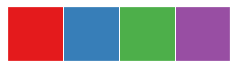

In [86]:
#create the different colors for the clusters
colors = sns.color_palette('Set1', n_clusters)
sns.palplot(colors)

Text(0.5, 1.0, 'Number of stations for each cluster')

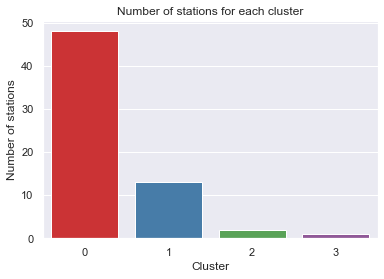

In [87]:
#show how many stations are in each cluster
sns.barplot(x=label_count.index, y=label_count, palette=colors)
plt.xlabel('Cluster')
plt.ylabel('Number of stations')
plt.title('Number of stations for each cluster')

In [88]:
kmeans.cluster_centers_

array([[0.96534867, 0.96646298, 0.96774729, 0.96876805, 0.97061212,
        0.97214413, 0.97060802, 0.96851276, 0.96803133, 0.97080599,
        0.96920871, 0.97001299, 0.97197994, 0.97274153, 0.97392793,
        0.97637587, 0.97582637, 0.97522387, 0.97252974, 0.9701474 ,
        0.96841917, 0.96807146, 0.96618498, 0.96558356],
       [0.83441694, 0.83753466, 0.84112409, 0.84638705, 0.85552379,
        0.87206604, 0.88996922, 0.92352047, 0.9366962 , 0.94685075,
        0.96342957, 0.96336155, 0.94444265, 0.92260706, 0.90558958,
        0.88246941, 0.86857702, 0.87142944, 0.87131853, 0.86184631,
        0.85158019, 0.84096485, 0.83901366, 0.8354716 ],
       [0.57150419, 0.57325242, 0.57433217, 0.57566894, 0.58115863,
        0.59953243, 0.70516114, 0.87474661, 0.9868212 , 1.        ,
        0.96063842, 0.89432972, 0.81640061, 0.72921923, 0.66537593,
        0.61960874, 0.58887401, 0.57212704, 0.56566571, 0.56522142,
        0.56734283, 0.56881906, 0.56793387, 0.5694177 ],
       [0.646

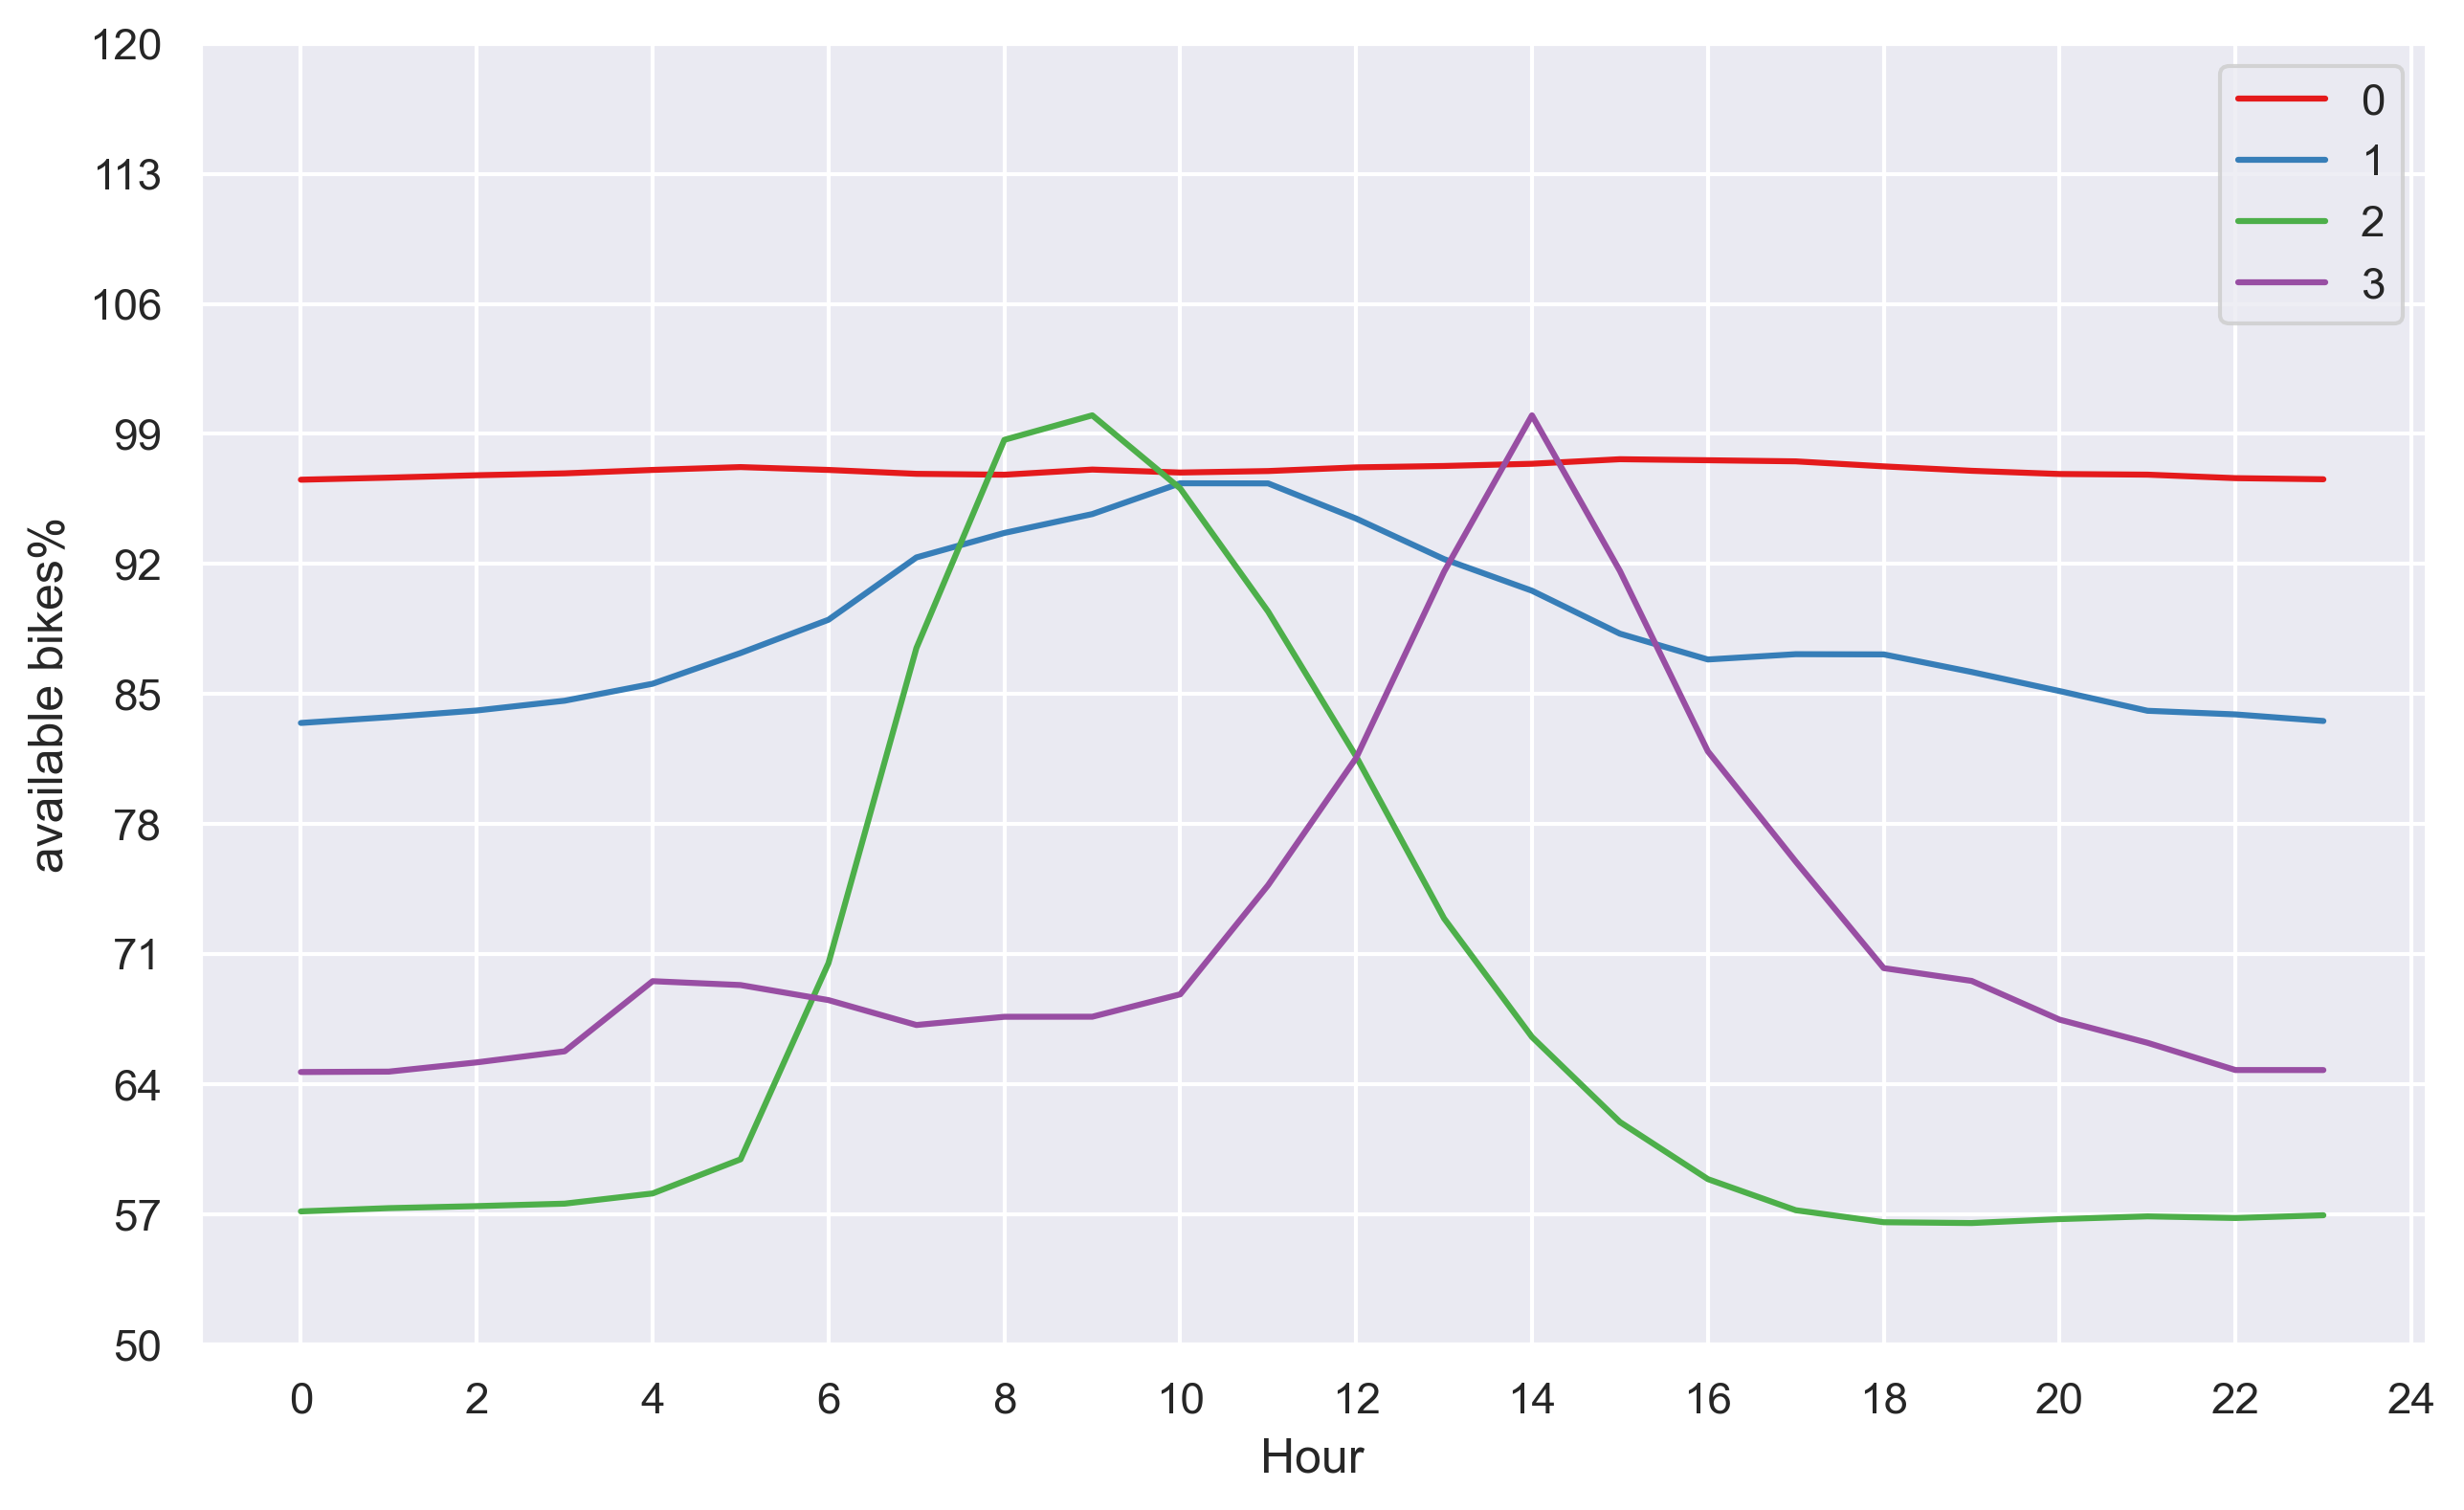

In [89]:
#in the following diagram there are 4 clusters based on their amount of available bikes 
#blue represents people that take the bikes in the morning and night hours and return them over the day 
#green is basically the opposite to blue
#red has an equally high amount of bikes, so they are either erroneous entries or these stations just aren't used a lot
#violet: a bit like blue,just not in the same extreme, returning bikes 10am-5pm

with sns.axes_style("darkgrid", {'xtick.major.size': 8.0}):
    fig, ax = plt.subplots(figsize=(10,6), dpi=300)

for k, label, color in zip(kmeans.cluster_centers_, range(n_clusters), colors):
    plt.plot(100*k, color=color, label=label)
    
plt.legend()
plt.xlabel('Hour')
plt.xticks(np.linspace(0, 24, 13))
plt.yticks(np.linspace(50, 120, 11))
plt.ylabel("available bikes%")
sns.despine()
plt.savefig("Data/Visualizations/clustersbyKM.png")

In [90]:
#evaluate the amount of clusters by silhouette coefficient
from sklearn.metrics import silhouette_samples, silhouette_score

NumberOfClusters=range(2,30)
silhouette_score_values=list()

for i in NumberOfClusters:
    
    classifier=KMeans(i,init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True)
    classifier.fit(df_norm.T)
    labels= classifier.predict(df_norm.T)
    print ("Number Of Clusters:")
    print (i)
    print ("Silhouette score value")
    print (silhouette_score(df_norm.T,labels ,metric='euclidean', sample_size=None, random_state=None))
    silhouette_score_values.append(silhouette_score(df_norm.T,labels ,metric='euclidean', sample_size=None, random_state=None))


Number Of Clusters:
2
Silhouette score value
0.7616076514493999
Number Of Clusters:
3
Silhouette score value
0.5981700815478276
Number Of Clusters:
4
Silhouette score value
0.60373345449293
Number Of Clusters:
5
Silhouette score value
0.5506198099827998
Number Of Clusters:
6
Silhouette score value
0.37308233650521805
Number Of Clusters:
7
Silhouette score value
0.3972562200610883
Number Of Clusters:
8
Silhouette score value
0.39637555092010157
Number Of Clusters:
9
Silhouette score value
0.36159355553644257
Number Of Clusters:
10
Silhouette score value
0.3620940116903893
Number Of Clusters:
11
Silhouette score value
0.34838105514229156
Number Of Clusters:
12
Silhouette score value
0.2861531303238892
Number Of Clusters:
13
Silhouette score value
0.34880835183157183
Number Of Clusters:
14
Silhouette score value
0.3472596055272931
Number Of Clusters:
15
Silhouette score value
0.2675396269930892
Number Of Clusters:
16
Silhouette score value
0.24314668884579585
Number Of Clusters:
17
Silhou

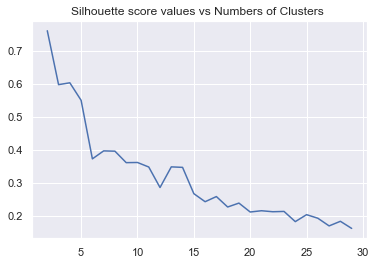

Optimal number of components is:
2


In [91]:
plt.plot(NumberOfClusters, silhouette_score_values)
plt.title("Silhouette score values vs Numbers of Clusters ")
plt.show()
 
Optimal_NumberOf_Components=NumberOfClusters[silhouette_score_values.index(max(silhouette_score_values))]
print ("Optimal number of components is:")
print (Optimal_NumberOf_Components)

In [92]:
#mapping the clusters on a map 
#Bonn position 
position = [50.7323, 7.1847]

In [93]:
#get the labels for the clusters 
dflabel = pd.DataFrame({"label": kmeans.labels_}, index=profile.columns)

In [94]:
#get the locations for merging of the data
#show clusters on a map 
locations = df_basis[['p_uid_start', 'p_name_start', 'latitude_start', 'longitude_start']]

In [95]:
locations = locations.merge(dflabel, right_index=True, left_on='p_uid_start')

In [96]:
locations['p_uid_start'] = locations['p_uid_start'].astype(str).str.replace("'", "&apos;")

In [97]:
mp = folium.Map(location=position, zoom_start=12, tiles='cartodbpositron')

In [98]:
#get the colors for the differnt stations on the map 
hex_colors = colors.as_hex()

In [99]:
#each circle represents a station and has its original color
for _,row in locations.iterrows():
    folium.CircleMarker(
        location=[row['latitude_start'], row['longitude_start']],
        radius=5,
        popup=row['p_name_start'],
        color=hex_colors[row['label']],
        fill=False,
        fill_opacity=0.5,
        fill_color=hex_colors[row['label']]
    ).add_to(mp)

In [100]:
mp.save("Data/Visualizations/KMeans_4_clusters.html".format(n_clusters))

#### Gaussian Clustering

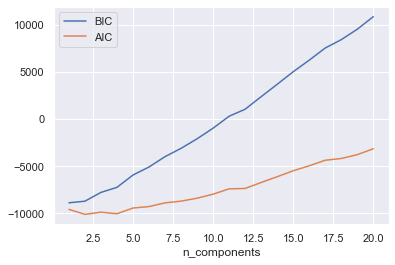

In [101]:
#the bic and aic isn't helping a lot in this case, so we will use the silhouette coefficient to evaluate the amount of clusters
number_of_clusters(df_norm.T)

In [102]:
n_clusters = 3
df_norm = profile / profile.max()
gmm = GaussianMixture(3, covariance_type='diag', random_state=0)
gmm.fit(df_norm.T)

labels = pd.Series(gmm.predict(df_norm.T))

label_count = labels.groupby(labels).count()
label_count

0    48
1     3
2    13
dtype: int64

Text(0.5, 1.0, 'Number of stations for each cluster')

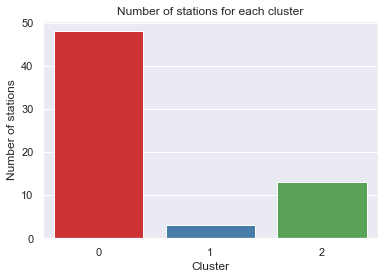

In [103]:
sns.barplot(x=label_count.index, y=label_count, palette=colors)
plt.xlabel('Cluster')
plt.ylabel('Number of stations')
plt.title('Number of stations for each cluster')

In [104]:
gmm.means_

array([[0.96534867, 0.96646299, 0.96774729, 0.96876806, 0.97061212,
        0.97214413, 0.97060803, 0.96851276, 0.96803133, 0.97080599,
        0.96920871, 0.97001299, 0.97197994, 0.97274153, 0.97392793,
        0.97637587, 0.97582637, 0.97522387, 0.97252974, 0.9701474 ,
        0.96841917, 0.96807146, 0.96618498, 0.96558356],
       [0.59650616, 0.59774614, 0.60012341, 0.60300102, 0.61924674,
        0.63079803, 0.69851609, 0.80710661, 0.88329614, 0.89209439,
        0.86987662, 0.84526731, 0.81611731, 0.79141271, 0.77691729,
        0.71848452, 0.66563927, 0.63467759, 0.61125944, 0.60866688,
        0.60313015, 0.59996104, 0.59448355, 0.595469  ],
       [0.83441694, 0.83753466, 0.84112409, 0.84638705, 0.85552379,
        0.87206604, 0.88996922, 0.92352047, 0.9366962 , 0.94685075,
        0.96342957, 0.96336155, 0.94444265, 0.92260706, 0.90558958,
        0.88246941, 0.86857702, 0.87142944, 0.87131853, 0.86184631,
        0.85158019, 0.84096485, 0.83901366, 0.8354716 ]])

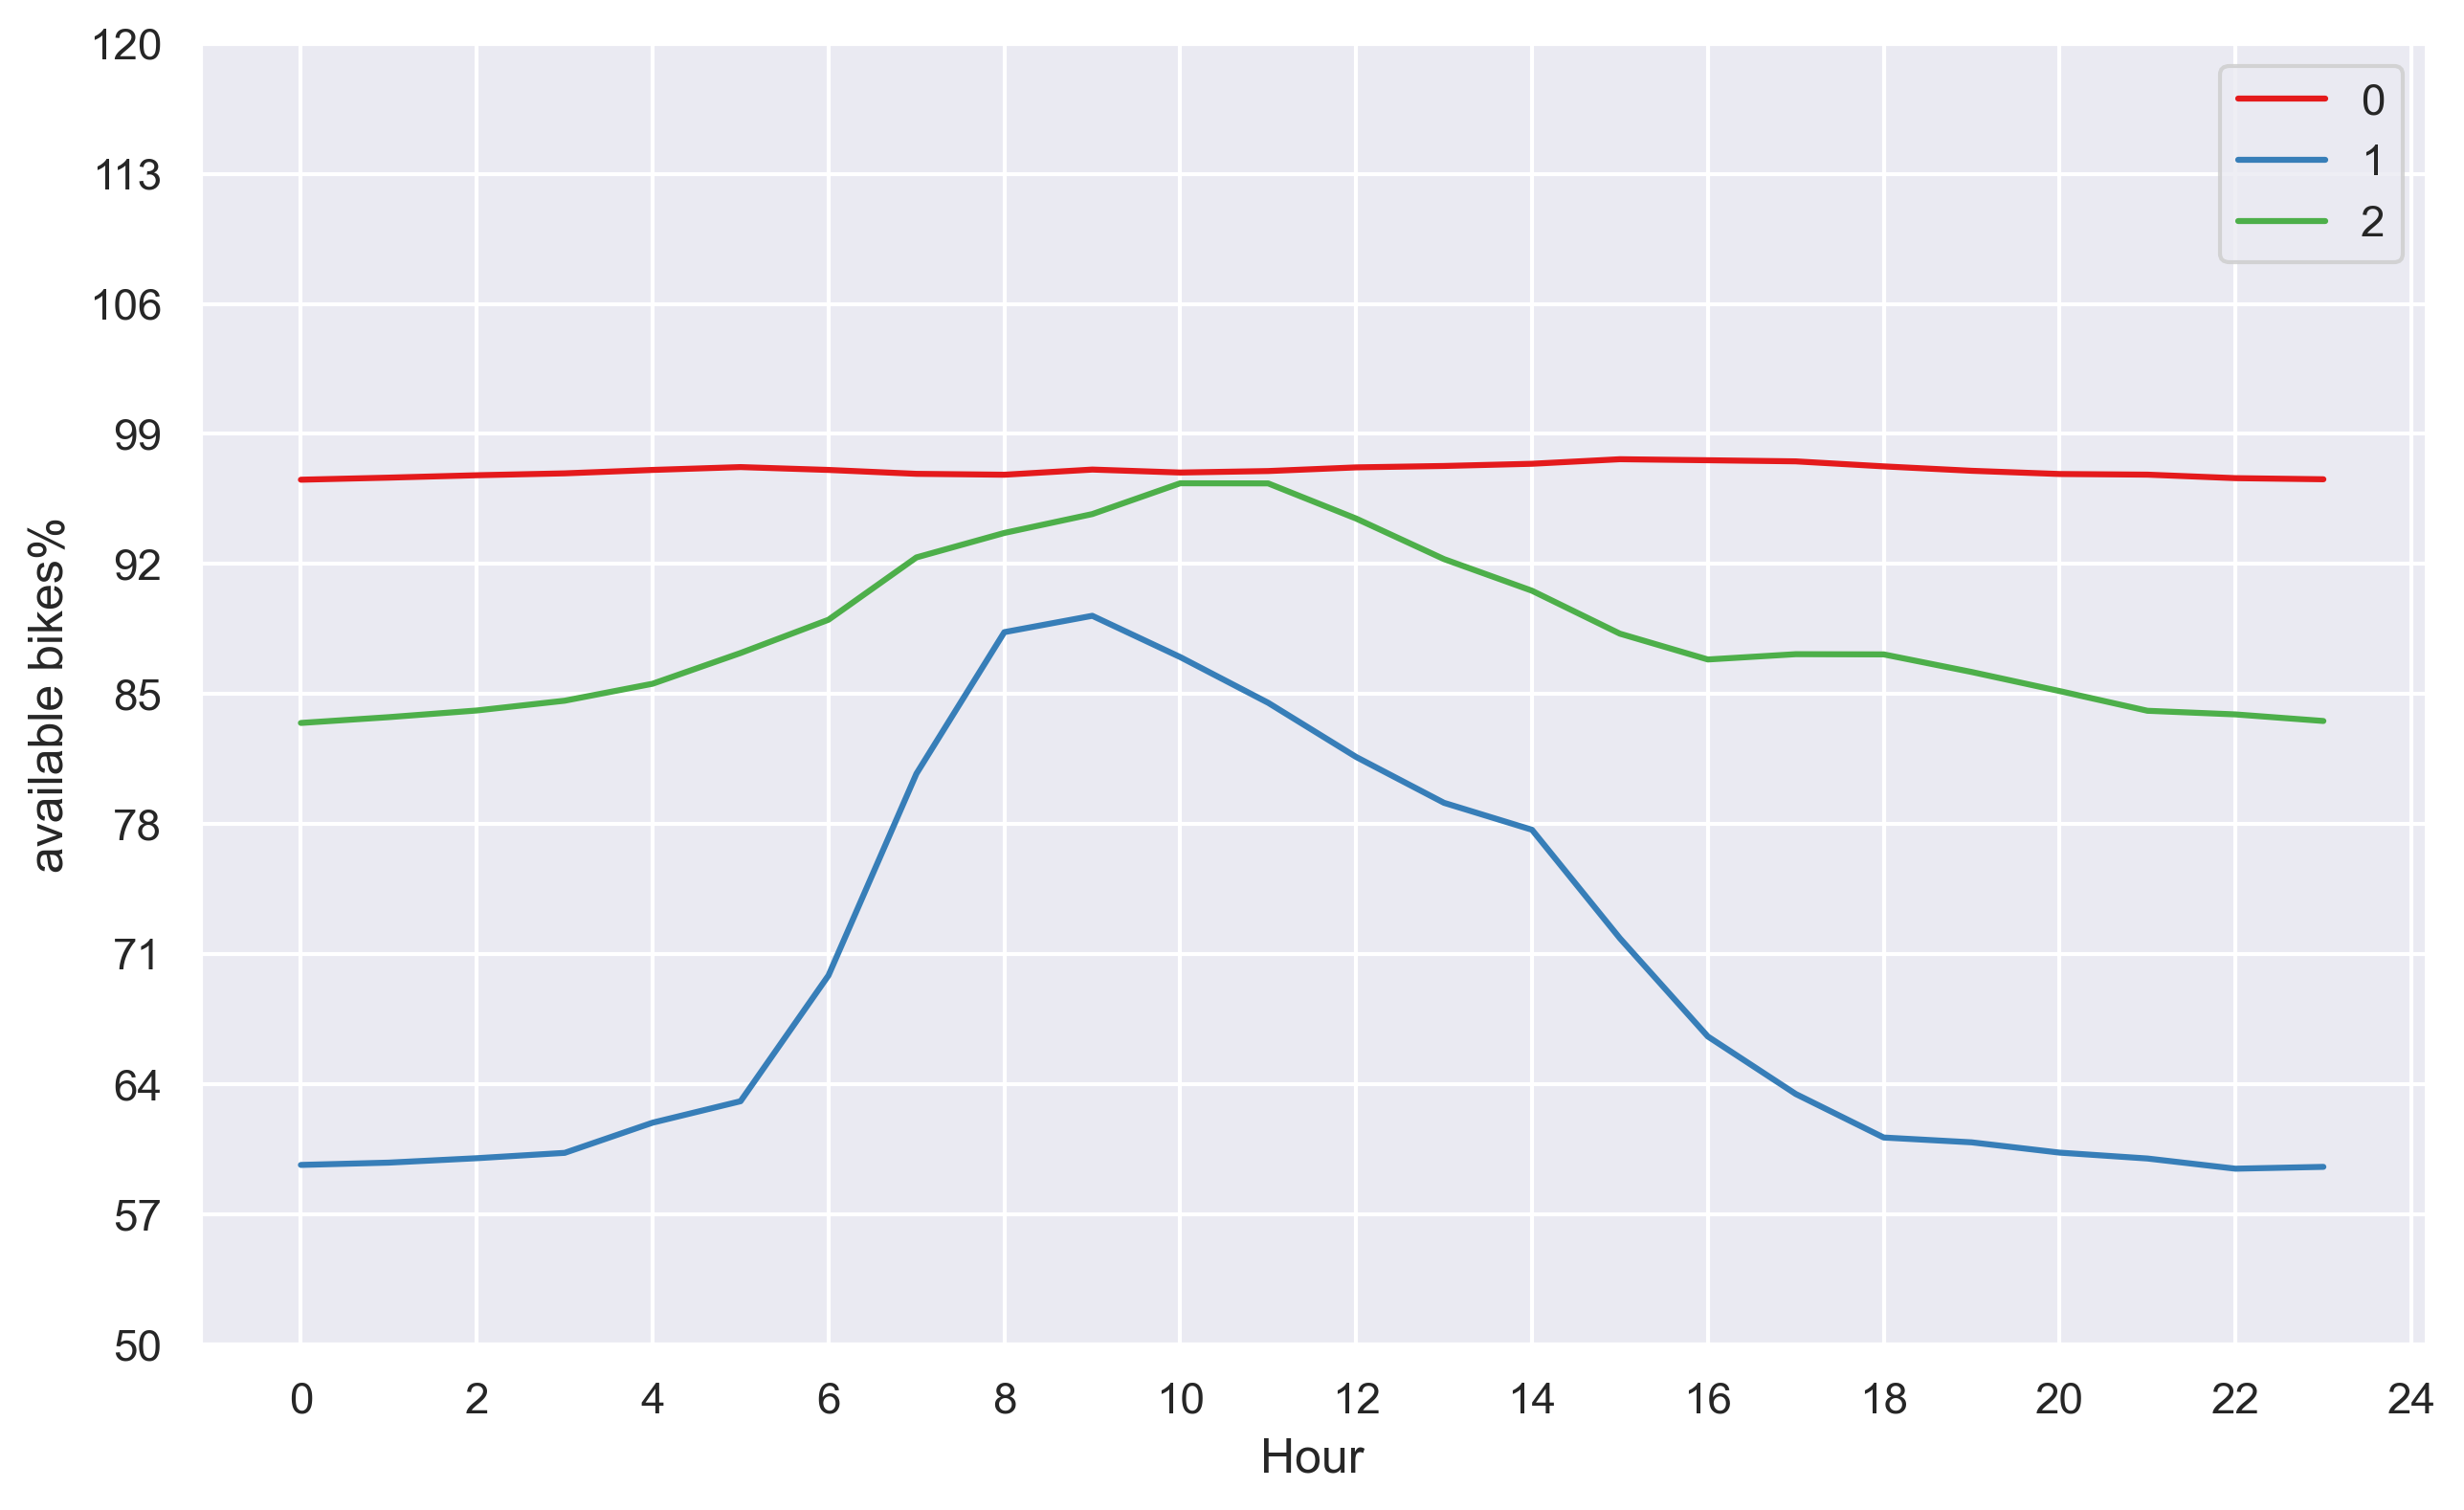

In [105]:
#we can see that the Gaussian Mixture has quite the different clusters compared to the KM 
#most clusters have more members than before 
#at the same time the patterns arent as extreme as for KM 

with sns.axes_style("darkgrid", {'xtick.major.size': 8.0}):
    fig, ax = plt.subplots(figsize=(10,6), dpi=300)

for k, label, color in zip(gmm.means_, range(n_clusters), colors):
    plt.plot(100*k, color=color, label=label)
    
plt.legend()
plt.xlabel('Hour')
plt.xticks(np.linspace(0, 24, 13))
plt.yticks(np.linspace(50, 120, 11))
plt.ylabel("available bikes%")
sns.despine()
plt.savefig("Data/Visualizations/clustersbyGMM.png")

In [106]:
#evaluate the clusters again 
#from sklearn.metrics import silhouette_samples, silhouette_score

NumberOfClusters=range(2,30)
silhouette_score_values=list()

for i in NumberOfClusters:
    
    classifier=GaussianMixture(i, covariance_type='diag', random_state=0)
    classifier.fit(df_norm.T)
    labels= classifier.predict(df_norm.T)
    print ("Number Of Clusters:")
    print (i)
    print ("Silhouette score value")
    print (silhouette_score(df_norm.T,labels ,metric='euclidean', sample_size=None, random_state=None))
    silhouette_score_values.append(silhouette_score(df_norm.T,labels ,metric='euclidean', sample_size=None, random_state=None))


Number Of Clusters:
2
Silhouette score value
0.5759001291451129
Number Of Clusters:
3
Silhouette score value
0.5981700815478276
Number Of Clusters:
4
Silhouette score value
0.32244833134832374
Number Of Clusters:
5
Silhouette score value
0.3280117042934262
Number Of Clusters:
6
Silhouette score value
0.32077506734569994
Number Of Clusters:
7
Silhouette score value
0.3189458134565146
Number Of Clusters:
8
Silhouette score value
0.29569561981357134
Number Of Clusters:
9
Silhouette score value
0.38565668570885353
Number Of Clusters:
10
Silhouette score value
0.2858072844019356
Number Of Clusters:
11
Silhouette score value
0.3739265060662883
Number Of Clusters:
12
Silhouette score value
0.28058910294327555
Number Of Clusters:
13
Silhouette score value
0.25894317517128285
Number Of Clusters:
14
Silhouette score value
0.2541566501672794
Number Of Clusters:
15
Silhouette score value
0.2490471790390402
Number Of Clusters:
16
Silhouette score value
0.26099614872443583
Number Of Clusters:
17
Sil

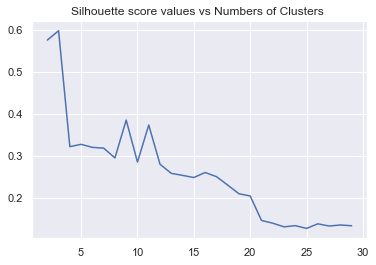

Optimal number of components is:
3


In [107]:
plt.plot(NumberOfClusters, silhouette_score_values)
plt.title("Silhouette score values vs Numbers of Clusters ")
plt.show()
 
Optimal_NumberOf_Components=NumberOfClusters[silhouette_score_values.index(max(silhouette_score_values))]
print ("Optimal number of components is:")
print (Optimal_NumberOf_Components)

In [108]:
#mapping the GMM version in the same way as before over the locations of the different stations 

In [109]:
labels2 = gmm.predict(df_norm.T)

In [110]:
dflabel2 = pd.DataFrame({"label": labels2}, index=profile.columns)

In [111]:
#combine the new labels with the original dataset 
locations2 = df_basis[['p_uid_start', 'p_name_start', 'latitude_start', 'longitude_start']]
locations2 = locations2.merge(dflabel2, right_index=True, left_on='p_uid_start')
locations2['p_uid_start'] = locations2['p_uid_start'].astype(str).str.replace("'", "&apos;")

In [112]:
mp2 = folium.Map(location=position, zoom_start=12, tiles='cartodbpositron')

In [113]:
hex_colors = colors.as_hex()

In [114]:
#each circle represents a station and has its original color
for _,row in locations2.iterrows():
    folium.CircleMarker(
        location=[row['latitude_start'], row['longitude_start']],
        radius=5,
        popup=row['p_name_start'],
        color=hex_colors[row['label']],
        fill=False,
        fill_opacity=0.5,
        fill_color=hex_colors[row['label']]
    ).add_to(mp2)

In [115]:
mp2.save("Data/Visualizations/GMM_3_clusters.html".format(n_clusters))

The Kmeans clustering showed a higher silhouette coefficent for 4 clusters while the GMM had a higher one for 3 clusters. Hence, we decided for a different amount of clusters. KMeans shows a distribution of one cluster that has a rising amount of available bikes from 6 to 12 am. Another has a rising 
amount of bikes from 12 till 6 pm. The third one one has slightly raised amount of available bike from around 6 am to 
2pm. And the last one has a constant amount of bikes over the whole day.
The Gaussian Mixture rather shows the difference among the different clusters to the one constant cluster. This is constantly above the other clusters, which have an extremely low number of bikes over the night and a rising amount of bikes over the day. KMeans shows that the stations that have a different periodical distribution that the other clusters are the UN-Campus, Bundeshaus and Juridicum which are all stations that have in common their proximity to the university or at least places of it. Hence, it can be said that Students form a specific customer group and use the bikes to specific times. The GMM also shows these stations as one cluster with a differnt distribution even though the diagram doesn't portray the distribution as extreme as KMeans. Most stations are part of the cluster that has a constant amount of bikes available. Another one with also less extreme changes has in common that these stations are all located close to the Rhine. 

### Clustering with the availability data 

#### Gaussian Mixture

Another kind of periodical availabilty has been calculated in the data preparation. While the data before can be read as a balance of availability and demand, this table views a negative value for available bikes if the hexagons in this case are in need of bikes and a positive if the stations has enough or too many bikes. Generally speaking it can be used to find overall spatial areas in need of more bikes or those that could give bikes to other areas.

In [116]:
availability = pd.read_csv('Data/availability_SVR.csv')

In [117]:
availability.head()

,Unnamed: 0,h3_hex_id,month,day,weekday,weekend,time_basket,available_bikes,center,center_x,...,urban_fabric,discontinuous_urban_fabric,continuous_urban_fabric,industry_commercial,green_urban_area,agricultural_area,forest,water_courses,distanceToCentralStation,distanceToUniversity
0,0,871fa1032ffffff,3,3,6,1,2,0.000000,"(50.65461869788869, 7.214118833734157)",50.654619,...,1,1,0,0,0,0,0,0,11.939101,11.955306
1,1,871fa1032ffffff,3,21,3,0,3,0.800000,"(50.65461869788869, 7.214118833734157)",50.654619,...,1,0,1,0,0,0,0,0,11.939101,11.955306
2,2,871fa1032ffffff,3,21,3,0,4,0.166667,"(50.65461869788869, 7.214118833734157)",50.654619,...,1,1,0,0,0,0,0,0,11.939101,11.955306
3,3,871fa1032ffffff,3,22,4,0,4,1.000000,"(50.65461869788869, 7.214118833734157)",50.654619,...,1,1,1,0,0,0,0,0,11.939101,11.955306
4,4,871fa1032ffffff,3,23,5,1,2,1.800000,"(50.65461869788869, 7.214118833734157)",50.654619,...,1,1,0,0,0,0,0,0,11.939101,11.955306


In [118]:
availability.dtypes

Unnamed: 0                      int64
h3_hex_id                      object
month                           int64
day                             int64
weekday                         int64
weekend                         int64
time_basket                     int64
available_bikes               float64
center                         object
center_x                      float64
center_y                      float64
temperature °C                float64
precipitaion_level (mm)       float64
precipitation y/n               int64
urban_fabric                    int64
discontinuous_urban_fabric      int64
continuous_urban_fabric         int64
industry_commercial             int64
green_urban_area                int64
agricultural_area               int64
forest                          int64
water_courses                   int64
distanceToCentralStation      float64
distanceToUniversity          float64
dtype: object

In [119]:
availability.available_bikes.describe()

count    46548.000000
mean        31.939619
std        205.672528
min      -1531.000000
25%          8.500000
50%         40.500000
75%         92.000000
max        651.400000
Name: available_bikes, dtype: float64

In [120]:
availability.columns

Index(['Unnamed: 0', 'h3_hex_id', 'month', 'day', 'weekday', 'weekend',
       'time_basket', 'available_bikes', 'center', 'center_x', 'center_y',
       'temperature °C', 'precipitaion_level (mm)', 'precipitation y/n',
       'urban_fabric', 'discontinuous_urban_fabric', 'continuous_urban_fabric',
       'industry_commercial', 'green_urban_area', 'agricultural_area',
       'forest', 'water_courses', 'distanceToCentralStation',
       'distanceToUniversity'],
      dtype='object')

In [121]:
availability.time_basket.describe()

count    46548.000000
mean         2.073086
std          1.428252
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          4.000000
Name: time_basket, dtype: float64

In [122]:
#create a table that calculates the mean for the different time_baskets and hexagons
pivot_av = pd.pivot_table(availability,index=["h3_hex_id"],values=["available_bikes"],
               columns=['time_basket'],aggfunc=[np.mean],fill_value=0)

pivot_av.head()

mean                                             
                available_bikes                                             
time_basket                   0          1          2          3           4
h3_hex_id                                                                   
871fa1032ffffff       27.028424  27.829060  26.287671  26.954545   25.905018
871fa1036ffffff       67.858061  70.215625  65.837059  68.122936   65.909844
871fa1102ffffff       63.154167  63.034202  62.419469  65.254769   63.317739
871fa1106ffffff       12.996774  13.722222  13.493897  14.247337   12.608718
871fa1110ffffff      -99.307505 -96.326023 -96.320468 -99.159531 -103.201267

In [123]:
availability_temp = availability.groupby(["h3_hex_id", "time_basket"])['available_bikes'].mean().unstack(fill_value=0).reset_index().rename_axis(None, axis=1)

In [124]:
pivot_av_gmm = availability_temp.set_index('h3_hex_id')

In [125]:
#evaluate the clusters again 
#from sklearn.metrics import silhouette_samples, silhouette_score

NumberOfClusters=range(2,30)
silhouette_score_values=list()

for i in NumberOfClusters:
    
    classifier=GaussianMixture(i, covariance_type='diag', random_state=0)
    classifier.fit(pivot_av_gmm)
    labels= classifier.predict(pivot_av_gmm)
    print ("Number Of Clusters:")
    print (i)
    print ("Silhouette score value")
    print (silhouette_score(pivot_av_gmm,labels ,metric='euclidean', sample_size=None, random_state=None))
    silhouette_score_values.append(silhouette_score(pivot_av_gmm,labels ,metric='euclidean', sample_size=None, random_state=None))


Number Of Clusters:
2
Silhouette score value
0.8612376730706517
Number Of Clusters:
3
Silhouette score value
0.5609797321335768
Number Of Clusters:
4
Silhouette score value
0.5411623373276392
Number Of Clusters:
5
Silhouette score value
0.5953325244072339
Number Of Clusters:
6
Silhouette score value
0.5988522366905993
Number Of Clusters:
7
Silhouette score value
0.5773450105627058
Number Of Clusters:
8
Silhouette score value
0.5959294600879568
Number Of Clusters:
9
Silhouette score value
0.5845438188145196
Number Of Clusters:
10
Silhouette score value
0.5776815253873935
Number Of Clusters:
11
Silhouette score value
0.5625625634597553
Number Of Clusters:
12
Silhouette score value
0.5788996842939346
Number Of Clusters:
13
Silhouette score value
0.5926159820270616
Number Of Clusters:
14
Silhouette score value
0.5604007781120857
Number Of Clusters:
15
Silhouette score value
0.4945070123907772
Number Of Clusters:
16
Silhouette score value
0.541992097244745
Number Of Clusters:
17
Silhouette 

In [126]:
n_clusters = 5
gmm = GaussianMixture(5, covariance_type='diag', random_state=0)
gmm.fit(pivot_av_gmm)

labels = pd.Series(gmm.predict(pivot_av_gmm))

label_count = labels.groupby(labels).count()
label_count

0    14
1     1
2    19
3     4
4     2
dtype: int64

In [127]:
#add the cluster column for later usage
pivot_av_gmm['cluster'] = gmm.fit_predict(pivot_av_gmm)


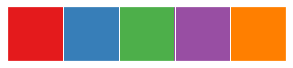

In [128]:
colors = sns.color_palette('Set1', n_clusters)
sns.palplot(colors)

Text(0.5, 1.0, 'Number of hexagons for each cluster')

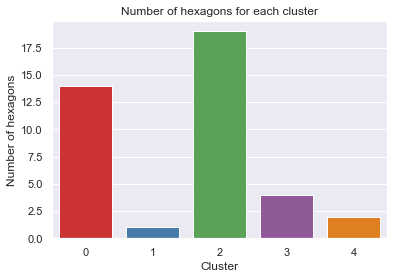

In [129]:
sns.barplot(x=label_count.index, y=label_count, palette=colors)
plt.xlabel('Cluster')
plt.ylabel('Number of hexagons')
plt.title('Number of hexagons for each cluster')

In [130]:
gmm.means_

array([[  67.5468813 ,   68.1778086 ,   66.02413274,   66.74887512,
          65.91989613],
       [-659.70272904, -659.30555556, -660.92690058, -663.51788856,
        -659.27631579],
       [  -1.72600563,   -1.69076021,   -2.05045021,   -1.9852016 ,
          -1.41034576],
       [ 214.51880647,  213.9951097 ,  213.96251998,  218.49662585,
         218.27188679],
       [-111.48879142, -112.16885965, -109.73333333, -108.31407625,
        -106.75804094]])

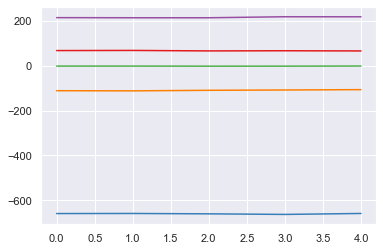

In [131]:
#the clusters are showing a straight line here because the values of each cluster for the different time baskets are 
#very close to each other. Hence it looks like the values aren't changing but they just aren't fluctuating a lot 
for k, label, color in zip(gmm.means_, range(n_clusters), colors):
    plt.plot(k, color=color, label=label)

In [132]:
pivot_av_gmm = pivot_av_gmm.reset_index()

In [133]:
hex_colors = colors.as_hex()

In [134]:
# Define the color standard color for the cluster 0
pivot_av_gmm['color'] = '#ff0000'
#colors for the other clusters
pivot_av_gmm.loc[pivot_av_gmm['cluster'] == 1, 'color'] = '#0000ff'
pivot_av_gmm.loc[pivot_av_gmm['cluster'] == 2, 'color'] = '#00ff00'
pivot_av_gmm.loc[pivot_av_gmm['cluster'] == 3, 'color'] = '#4e2c7f'
pivot_av_gmm.loc[pivot_av_gmm['cluster'] == 4, 'color'] = '#ff8000'

In [135]:
av = availability[['h3_hex_id', 'center']]
av_new = pd.merge(pivot_av_gmm, av, on='h3_hex_id')
av_new

,h3_hex_id,0,1,2,3,4,cluster,color,center
0,871fa1032ffffff,27.028424,27.829060,26.287671,26.954545,25.905018,2,#00ff00,"(50.65461869788869, 7.214118833734157)"
1,871fa1032ffffff,27.028424,27.829060,26.287671,26.954545,25.905018,2,#00ff00,"(50.65461869788869, 7.214118833734157)"
2,871fa1032ffffff,27.028424,27.829060,26.287671,26.954545,25.905018,2,#00ff00,"(50.65461869788869, 7.214118833734157)"
3,871fa1032ffffff,27.028424,27.829060,26.287671,26.954545,25.905018,2,#00ff00,"(50.65461869788869, 7.214118833734157)"
4,871fa1032ffffff,27.028424,27.829060,26.287671,26.954545,25.905018,2,#00ff00,"(50.65461869788869, 7.214118833734157)"
...,...,...,...,...,...,...,...,...,...
46543,871fa1c4dffffff,178.524378,177.060423,175.477193,177.335882,177.264133,3,#4e2c7f,"(50.758136109063116, 7.0453021632135675)"
46544,871fa1c4dffffff,178.524378,177.060423,175.477193,177.335882,177.264133,3,#4e2c7f,"(50.758136109063116, 7.0453021632135675)"
46545,871fa1c4dffffff,178.524378,177.060423,175.477193,177.335882,177.264133,3,#4e2c7f,"(50.758136109063116, 7.0453021632135675)"
46546,871fa1c4dffffff,178.524378,177.060423,175.477193,177.335882,177.264133,3,#4e2c7f,"(50.758136109063116, 7.0453021632135675)"


#### KMeans

In [136]:
pivot_av

mean                                      \
                available_bikes                                       
time_basket                   0           1           2           3   
h3_hex_id                                                             
871fa1032ffffff       27.028424   27.829060   26.287671   26.954545   
871fa1036ffffff       67.858061   70.215625   65.837059   68.122936   
871fa1102ffffff       63.154167   63.034202   62.419469   65.254769   
871fa1106ffffff       12.996774   13.722222   13.493897   14.247337   
871fa1110ffffff      -99.307505  -96.326023  -96.320468  -99.159531   
871fa1111ffffff       93.155258   95.094427   92.353079   93.859587   
871fa1112ffffff     -123.670078 -128.011696 -123.146199 -117.468622   
871fa1113ffffff       77.563840   83.747801   65.970760   56.507647   
871fa1114ffffff      322.802144  319.223684  324.915789  337.424047   
871fa1115ffffff      217.597549  221.692771  217.807625  219.800000   
871fa1116ffffff     -659.702729 -659.305556 -660.926901 -663.517889   
871fa1118ffffff        0.000000    0.000000   -0.400000    0.000000   
871fa111affffff       11.236395   11.431604   11.586032   13.556184   
871fa111cffffff       10.015707    9.893130    9.873729    9.936683   
871fa111dffffff        0.611111    1.000000    0.733333    0.200000   
871fa111effffff       90.399510   90.135294   91.064327   90.961062   
871fa1132ffffff      139.217647  138.070149  137.716471  139.495882   
871fa1133ffffff       43.571659   41.944444   42.728467   42.112397   
871fa1136ffffff        0.916667    1.016129    1.073239    1.360870   
871fa1185ffffff        0.000000    1.000000    0.000000    0.000000   
871fa118cffffff        0.000000    0.000000    0.150000    0.000000   
871fa118dffffff       48.004870   48.427007   48.211480   51.883934   
871fa11a0ffffff      -37.423280  -37.339286  -38.498684  -41.379487   
871fa11a1ffffff      -45.134868  -49.800000  -48.459184  -50.380702   
871fa11a3ffffff       11.722222   13.244898   11.621277   12.036111   
871fa11a4ffffff      -20.669202  -21.196517  -20.896370  -21.539130   
871fa11a5ffffff       24.110410   23.052326   23.807761   24.970159   
871fa11a8ffffff       46.958580   48.554545   47.991228   49.306269   
871fa11a9ffffff       42.409046   42.070796   42.384795   43.289941   
871fa11aaffffff        0.000000    4.000000    0.900000    2.400000   
871fa11abffffff       50.599112   50.548930   49.278235   51.732326   
871fa11acffffff       71.436647   69.358407   70.116374   73.427647   
871fa11adffffff       59.198529   58.513196   55.416959   55.730792   
871fa11aeffffff        0.000000    1.200000    0.533333    0.000000   
871fa11b1ffffff        0.333333    0.000000    0.000000    0.000000   
871fa1c48ffffff       91.319182   93.745487   92.088757   93.341284   
871fa1c49ffffff      100.323099   99.393275   98.766667   99.243402   
871fa1c4affffff       -4.386525   -5.560000   -4.826667   -5.495238   
871fa1c4bffffff      -23.961045  -25.423423  -25.750292  -24.394135   
871fa1c4dffffff      178.524378  177.060423  175.477193  177.335882   

                             
                             
time_basket               4  
h3_hex_id                    
871fa1032ffffff   25.905018  
871fa1036ffffff   65.909844  
871fa1102ffffff   63.317739  
871fa1106ffffff   12.608718  
871fa1110ffffff -103.201267  
871fa1111ffffff   94.175439  
871fa1112ffffff -110.314815  
871fa1113ffffff   54.849415  
871fa1114ffffff  334.601365  
871fa1115ffffff  220.235380  
871fa1116ffffff -659.276316  
871fa1118ffffff    0.000000  
871fa111affffff   12.950000  
871fa111cffffff    9.891461  
871fa111dffffff    0.700000  
871fa111effffff   90.578947  
871fa1132ffffff  141.055556  
871fa1133ffffff   41.386905  
871fa1136ffffff    1.086667  
871fa1185ffffff    0.000000  
871fa118cffffff    0.500000  
871fa118dffffff   48.222710  
871fa11a0ffffff  -38.738192  
871fa11a1ffffff  -40.661836  
871fa11a3ffffff   11.314312  
871fa11a4ffffff  -20.256146  
87

In [137]:
#evaluate the clusters again 
#from sklearn.metrics import silhouette_samples, silhouette_score

NumberOfClusters=range(2,30)
silhouette_score_values=list()

for i in NumberOfClusters:
    
    classifier=KMeans(i,init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True)
    classifier.fit(pivot_av)
    labels= classifier.predict(pivot_av)
    print ("Number Of Clusters:")
    print (i)
    print ("Silhouette score value")
    print (silhouette_score(pivot_av,labels ,metric='euclidean', sample_size=None, random_state=None))
    silhouette_score_values.append(silhouette_score(pivot_av,labels ,metric='euclidean', sample_size=None, random_state=None))


Number Of Clusters:
2
Silhouette score value
0.8612376730706517
Number Of Clusters:
3
Silhouette score value
0.6571925358582298
Number Of Clusters:
4
Silhouette score value
0.5510120952793706
Number Of Clusters:
5
Silhouette score value
0.5943243340199118
Number Of Clusters:
6
Silhouette score value
0.5988522366905993
Number Of Clusters:
7
Silhouette score value
0.5900941632515629
Number Of Clusters:
8
Silhouette score value
0.6010593739368852
Number Of Clusters:
9
Silhouette score value
0.5845438188145196
Number Of Clusters:
10
Silhouette score value
0.5670624560760628
Number Of Clusters:
11
Silhouette score value
0.5606320100144033
Number Of Clusters:
12
Silhouette score value
0.5762788611928823
Number Of Clusters:
13
Silhouette score value
0.5926159820270616
Number Of Clusters:
14
Silhouette score value
0.5604007781120857
Number Of Clusters:
15
Silhouette score value
0.6033705848008944
Number Of Clusters:
16
Silhouette score value
0.5782970635252289
Number Of Clusters:
17
Silhouette

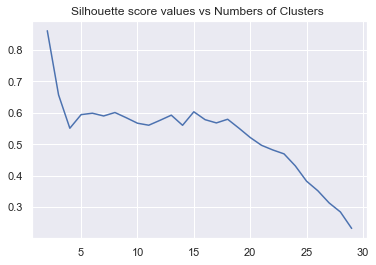

Optimal number of components is:
2


In [138]:
#visualisation of the silhouette coefficient
plt.plot(NumberOfClusters, silhouette_score_values)
plt.title("Silhouette score values vs Numbers of Clusters ")
plt.show()
 
Optimal_NumberOf_Components=NumberOfClusters[silhouette_score_values.index(max(silhouette_score_values))]
print ("Optimal number of components is:")
print (Optimal_NumberOf_Components)

In [139]:
#kmeans clustering
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(pivot_av)
labels = pd.Series(kmeans.labels_)

label_count = labels.groupby(labels).count()
label_count

0    15
1     1
2    19
3     3
4     2
dtype: int64

Text(0.5, 1.0, 'Number of hexagons for each cluster')

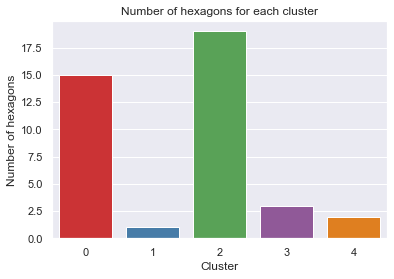

In [140]:
sns.barplot(x=label_count.index, y=label_count, palette=colors)
plt.xlabel('Cluster')
plt.ylabel('Number of hexagons')
plt.title('Number of hexagons for each cluster')

In [141]:
kmeans.cluster_centers_

array([[  72.34461391,   72.85690582,   70.82294193,   71.61799169,
          70.94837325],
       [-659.70272904, -659.30555556, -660.92690058, -663.51788856,
        -659.27631579],
       [  -1.71599357,   -1.68051886,   -2.04057496,   -1.9750949 ,
          -1.40078883],
       [ 239.64135713,  239.32562609,  239.40020236,  244.85330976,
         244.03362573],
       [-111.48879142, -112.16885965, -109.73333333, -108.31407625,
        -106.75804094]])

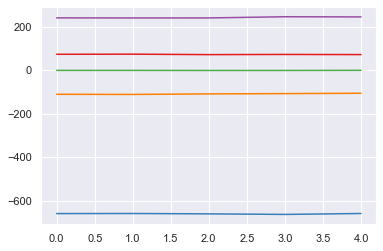

In [142]:
#the clusters are showing a straight line here because the values of each cluster for the different time baskets are 
#very close to each other. Hence it looks like the values aren't changing but they just aren't fluctuating a lot 
for k, label, color in zip(kmeans.cluster_centers_, range(n_clusters), colors):
    plt.plot(k, color=color, label=label)

In [143]:
#add the cluster column for later usage
pivot_av['cluster'] = kmeans.predict(pivot_av)

In [144]:
hex_colors = colors.as_hex()

In [145]:
# Define the color standard color for the cluster 0
pivot_av['color'] = '#ff0000'
#colors for the other clusters
pivot_av.loc[pivot_av['cluster'] == 1, 'color'] = '#0000ff'
pivot_av.loc[pivot_av['cluster'] == 2, 'color'] = '#00ff00'
pivot_av.loc[pivot_av['cluster'] == 3, 'color'] = '#4e2c7f'
pivot_av.loc[pivot_av['cluster'] == 4, 'color'] = '#ff8000'

The Silhouette Coefficient shows for both cluster methods a high percentage for just 2 clusters. However, with 2 clusters the distribution would be among almost all hexagons and the ones that have extremely low values. Hence, we decided for 5 clusters which shows are slightly raised value compared to the amount of clusters before. Like this we have those stations that have averagely 60 to 70 bikes available, 2) the extreme one with almost -700, 3) One that is just slightly negative around -1, 4) One that has high positive values with around 200 to 300 plus and lastly one that has also quite high negative values with around -100. 

### Some general clusters

#### Temperature

In [146]:
#read the temperature data 
#the data had some erroneous data with -999 degrees which needed to be dropped 
tp = pd.read_csv("Data/final_trips_and_weather.csv")

In [147]:
tpc = tp.groupby('temperature °C', as_index=False).count()

In [148]:
tpc = tpc[['temperature °C', 'index_start']]
tpc = tpc.rename(columns={"index_start": "amount"})

In [149]:
tpc = tpc[tpc['temperature °C'] > -999]

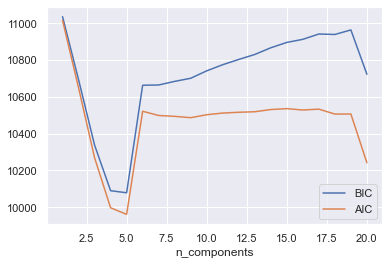

In [150]:
number_of_clusters(tpc)

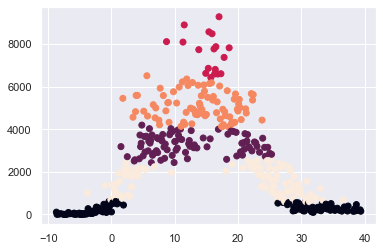

In [151]:
#Gaussian Mixture
gmm = GaussianMixture(5, covariance_type='diag')
gmm.fit(tpc)
cluster_label = gmm.predict(tpc)
plt.scatter(tpc['temperature °C'], tpc.amount, c=cluster_label);

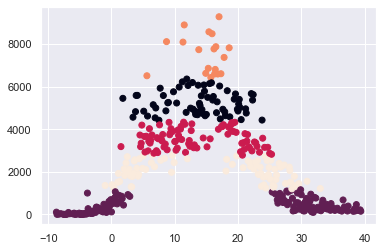

In [152]:
#KMeans
km = KMeans(n_clusters=5, init='k-means++', max_iter=300, algorithm='auto')
km.fit(tpc)
cluster_label = km.predict(tpc)
plt.scatter(tpc['temperature °C'], tpc.amount, c=cluster_label);

Here we can see that there is an overall distribution of those trips that went during the average temperatures and it is getting less and less trips the more extreme the weather gets. 

#### Distance

The distance showed to have similar patterns as the duration. Without much surprise there were a lot less long trips and way more shorter trips, same goes for the distance with a lot less very long trips and more short trips. Since the distance was a very long float number, the entries had to be changed. So trips shorter than 1km were disregarded and the numbers were rounded to 2 decimals. 

In [153]:
distc = tp.groupby('distance', as_index=False).count()

In [154]:
distc = distc[['distance', 'index_start']]
distc = distc.rename(columns={"index_start": "amount"})

In [155]:
distc = distc[distc['distance'] > 1]
distc = distc[distc['amount'] > 1]

In [156]:
distc['distance'] = distc.distance.round(decimals=2)

In [157]:
distc = distc.groupby('distance', as_index=False).count()

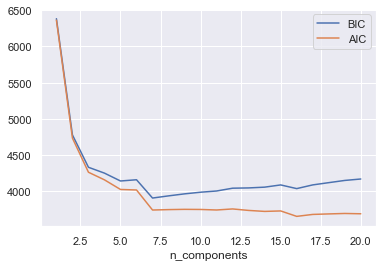

In [158]:
number_of_clusters(distc)

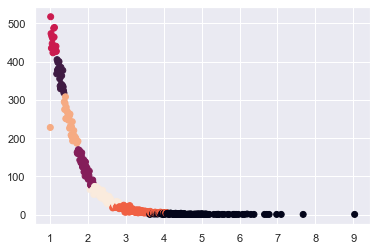

In [159]:
#Gaussian Mixture
gmm = GaussianMixture(7, covariance_type='diag')
gmm.fit(distc)
cluster_label = gmm.predict(distc)
plt.scatter(distc['distance'], distc.amount, c=cluster_label);

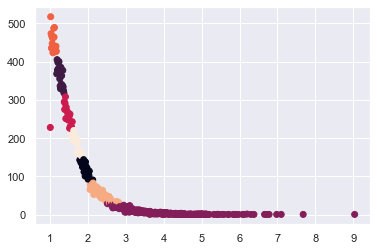

In [160]:
#KMeans
km = KMeans(n_clusters=7, init='k-means++', max_iter=300, algorithm='auto')
km.fit(distc)
cluster_label = km.predict(distc)
plt.scatter(distc['distance'], distc.amount, c=cluster_label);

It can be seen that the most trips are done in the shorter sections, between 1 and 2 kilometers. While trips between 3 and 9 km are almost extremely rare. 

In [161]:
tp.columns

Index(['Unnamed: 0', 'index_start', 'p_place_type_start', 'p_bike_racks_x',
       'p_booked_bikes_x', 'p_free_racks_x', 'datetime_start',
       'b_number_start', 'trip_start', 'p_uid_start', 'p_bikes_x',
       'latitude_start', 'longitude_start', 'p_name_start', 'p_number_start',
       'p_bike_start', 'p_spot_start', 'index_end', 'p_place_type_end',
       'p_bike_racks_y', 'p_booked_bikes_y', 'p_free_racks_y', 'datetime_end',
       'b_number_end', 'trip_end', 'p_uid_end', 'p_bikes_y', 'latitude_end',
       'longitude_end', 'p_name_end', 'p_number_end', 'p_bike_end',
       'p_spot_end', 'trip_duration', 'weekday', 'distance', 'weekend', 'day',
       'month', 'hour', 'minute', 'temperature °C', 'relative_humidity',
       'precipitaion_level (mm)', 'precipitation y/n',
       'average_wind_speed (m/s)'],
      dtype='object')

#### Duration

In [162]:
dura = tp.groupby('trip_duration', as_index=False).count()

In [163]:
dura = dura[['trip_duration', 'index_start']]
dura = dura.rename(columns={"index_start": "amount"})

In [164]:
dura

,trip_duration,amount
0,2,143870
1,3,86792
2,4,67224
3,5,79531
4,6,73869
...,...,...
834,1323,1
835,1333,1
836,1338,1
837,1352,1


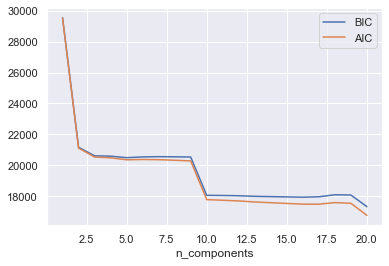

In [165]:
number_of_clusters(dura)

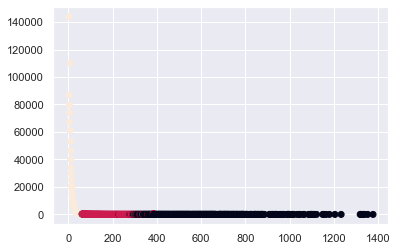

In [166]:
#Gaussian Mixture
gmm = GaussianMixture(3, covariance_type='diag')
gmm.fit(dura)
cluster_label = gmm.predict(dura)
plt.scatter(dura['trip_duration'], dura.amount, c=cluster_label);

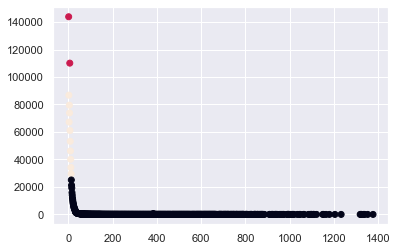

In [167]:
#KMeans
km = KMeans(n_clusters=3, init='k-means++', max_iter=300, algorithm='auto')
km.fit(dura)
cluster_label = km.predict(dura)
plt.scatter(dura['trip_duration'], dura.amount, c=cluster_label);

As mentioned before the duration shows a similar pattern to the distance. Many short trips and less long trips. 